<a href="https://colab.research.google.com/github/ravichas/bioinformatics/blob/main/RNASeqUsingStar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, I will show you how to carry out RNASeq analysis using STAR software.
For this example, I will use the following publication, PMC8140103.

Brief description of the work carried out in the above-mentioned publication:

This study investigated the role of telomeres (the ends of chromosomes) in vascular smooth muscle cells (VSMC's) and how they contribute to inflammation and vascular disease. The researchers found that stress-induced premature senescence (yes IP yes) under mutated protein (TRF2T188A) both cost persistent telomere damage in VSMC's this damage was linked to a pro-inflammatory phenotype, which was found to be regulated by a pathway called cGAS-STING. The study also found that inflammation, rather than impaired cell proliferation, was a primary effect of VSMC senescence. This research suggests that managing telomere damage in VSMCs could be an important strategy for managing chronic inflammation in vascular disease.

We will be using the samples from this study (4 controls and 4 cases) and carry out the following steps:

* Download the human chromosome and annotation files
* Prepare the human chromosome (indexing) using STAR
* Download the NGS samples
* Map the NGS reads to the Chromosome reference
* Count the reads mapped to the chromosome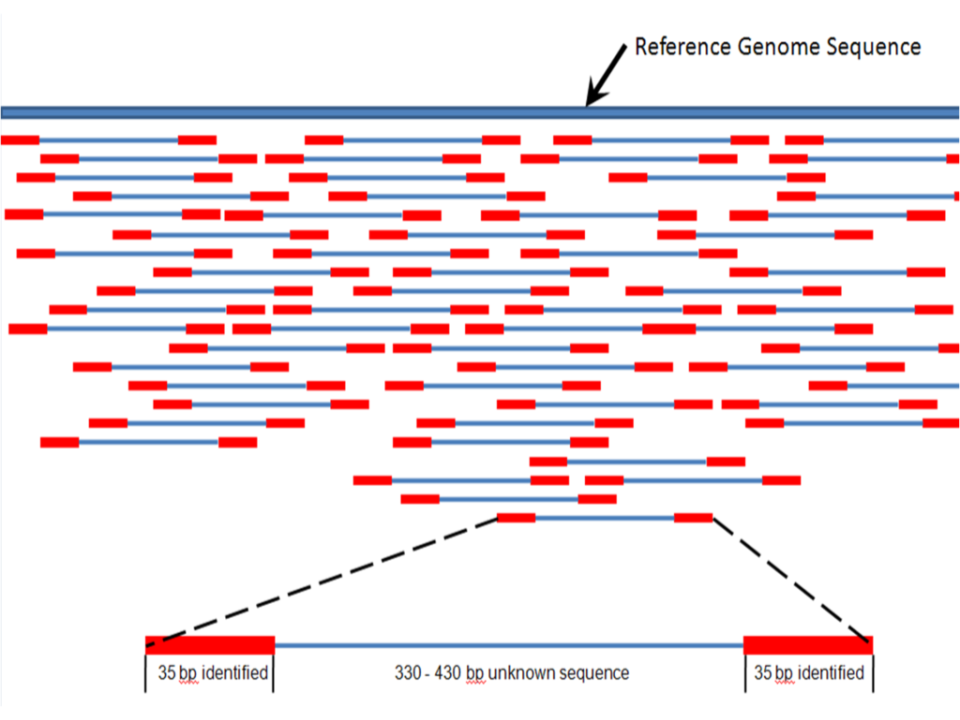



In [ ]:
%bash

# prepared for Linux VM

cat /etc/os-release

# debian
sudo apt update
sudo apt install git
sudo apt-get install -y parallel

mkdir -p $HOME/Genomics/RNASeq1
mkdir -p $HOME/Software

cd $HOME/Software

git clone https://github.com/alexdobin/STAR.git
export PATH=$PATH:$HOME/Software/STAR/bin/Linux_x86_64
export PATH=$PATH:$HOME/Software/sratoolkit.3.1.0-ubuntu64/bin


# ldd STAR
sudo apt-get install libgomp1
# ldd STAR

cd $HOME/Genomics

wget https://ftp.ensembl.org/pub/release-111/fasta/homo_sapiens/dna/Homo_sapiens.GRCh38.dna_sm.primary_assembly.fa.gz
wget https://ftp.ensembl.org/pub/release-111/gtf/homo_sapiens/Homo_sapiens.GRCh38.111.gtf.gz

gunzip *.gz

# 4.4 GB of *fa/*.gtf

# nproc

STAR --runMode genomeGenerate --genomeDir ref/ --genomeFastaFiles GRCh38.primary_assembly.genome.fa \
      --sjdbGTFfile Homo_sapiens.GRCH38.111.gtf --runThreadN 16

echo -e "SRR1416878\nSRR14168771\nSRR14168776" > sra_list.txt

cat sra_list.txt | parallel --eta --verbose "fastq-dump" -O data -F {}"

cd $HOME/genome
mkdir mapped
cd data

for file in *.fastq; do STAR --runMode alignReads --genomeDir ../ref/ \
   outSAMtype BAM SortedByCoordinate --readFilesIn ${file} \
  --runThreadN 16 --outFileNamePrefix ../mapped/${file}; done

#house-keeping

cd ..
mkdir bams
mv mapped/*.bam bams/.
cd bams


for i in *.bam; do newname=$(echo $i | cut -d '.' -f 1); mv -- "$i" \
                             "$newname".bam; done


cd ..


# do STAR counting